In [1]:
# grep -i "gw01.extranet.frachtwerk.de filterlog" pfsense.log > pfsense.csv
import pandas
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

In [2]:
# Full parquet needs to be build
# df = pd.read_parquet('./data/df_v4.parquet', engine='pyarrow') 
df = pandas.read_parquet('./data/df_v4_10000', engine='pyarrow') 

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (17,20,21,24,25,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
test_df = df.head(1000)
test_df[22] # data length (bandwith)

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
995    0.0
996    0.0
997    0.0
998    0.0
999    0.0
Name: 22, Length: 1000, dtype: float64

In [3]:
# Show data length statistics
df['data_length'].describe()
# Minimum value is -2 which does not make any sense in this context

count    1.531717e+07
mean     8.438166e+02
std      5.313890e+04
min     -2.000000e+01
25%      0.000000e+00
50%      0.000000e+00
75%      2.800000e+01
max      5.766840e+06
Name: 22, dtype: float64

In [4]:
# Date conversion (More detailed description in describe_time.ipynb)
df['date_minutes'] = df['date'].dt.strftime('%m-%d %H:%M')
df['date_minutes']

0           09-07 11:45
1           09-07 11:45
2           09-07 11:46
3           09-07 11:46
4           09-07 11:46
               ...     
15393163    12-07 09:21
15393164    12-07 09:21
15393165    12-07 09:21
15393166    12-07 09:22
15393167    12-07 09:22
Name: date_minutes, Length: 15393168, dtype: object

In [8]:
# Sum up data_length for each minute
grouped = df.groupby('date_minutes')[22].sum()
df_grouped = grouped.to_frame('data_length_sum')
df_grouped['date_minutes'] = df_grouped.index
df_grouped

,data_length_sum,date_minutes
date_minutes,,
09-07 11:45,0.0,09-07 11:45
09-07 11:46,8.0,09-07 11:46
09-07 11:47,37.0,09-07 11:47
09-07 11:48,0.0,09-07 11:48
09-07 11:49,420.0,09-07 11:49
...,...,...
12-07 09:18,0.0,12-07 09:18
12-07 09:19,420.0,12-07 09:19
12-07 09:20,0.0,12-07 09:20


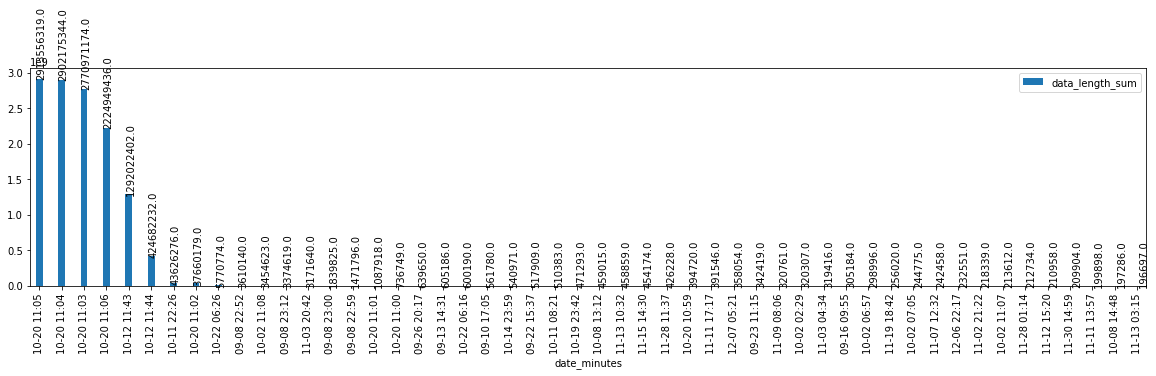

In [9]:
# Detect firewall log anomalies (Bandwith per minute, top 50)
ax = df_grouped.sort_values(by='data_length_sum', ascending=False)[:50].plot(kind='bar',figsize=(20,4), width=0.3)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005), rotation=90)

In [30]:
df_grouped['data_length_sum'].describe()

count    1.305930e+05
mean     9.897071e+04
std      1.550425e+07
min     -4.000000e+00
25%      2.900000e+01
50%      1.360000e+02
75%      8.800000e+02
max      2.913556e+09
Name: data_length_sum, dtype: float64

# Data_length_sum per minute (Top 50)
Until the 8th (10-20 11:02) entry from the left we seem to have a higher log count per minute than usual (bar chart).
Looking at the overall mean all the entries seem unusual high as a data_length_sum of 98970,71 per minute are the norm.

### Analysis of top 18
1. 10-20 11:05 - 2.913.556.319 = 1 & 2 & 3 & 4 Possible denial of service attack
2. 10-20 11:04 - = 1 & 2 & 3 & 4 & 8 Possible denial of service attack
3. 10-20 11:03 - = 1 & 2 & 3 & 4 & 8 Possible denial of service attack
4. 10-20 11:06 - = 1 & 2 & 3 & 4 & 8 Possible denial of service attack
5. 10-12 11:43 - = 5 & 6 Possible denial of service attack
6. 10-12 11:44 - = 5 & 6 Possible denial of service attack
7. 10-11 22:26 - = Possible denial of service attack
8. 10-20 11:02 - = 1 & 2 & 3 & 4 & 8 Possible denial of service attack

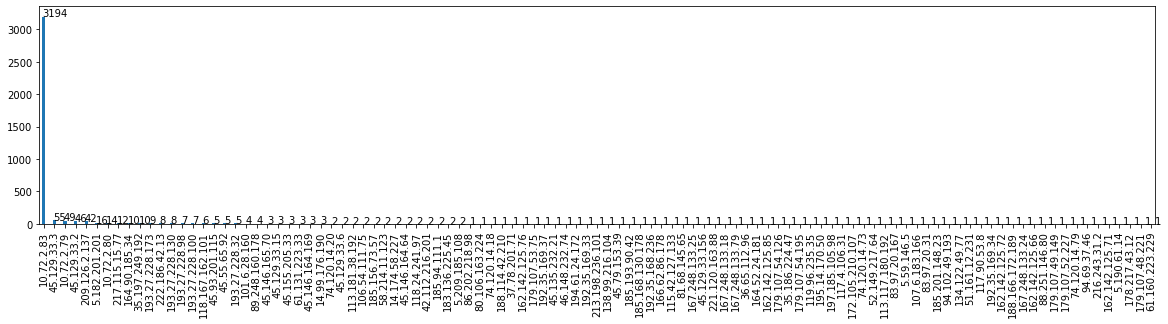

In [14]:
# 1. 10-20 11:05 & 10-20 11:04 & 10-20 11:03 & 10-20 11:06 & 10-20 11:02 = Possible denial of service attack
is_date = (df['date_minutes'] == '10-20 11:06') | (df['date_minutes'] == '10-20 11:05') | (df['date_minutes'] == '10-20 11:04') | (df['date_minutes'] == '10-20 11:03') | (df['date_minutes'] == '10-20 11:02')
is_date_df = df[is_date]
is_date_df
# list source ips involved in the attack
ax = is_date_df[18].value_counts().plot(kind='bar',figsize=(20,4), width=0.3)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

# Dangerous IP is 10.72.2.83
No details - internal IP?

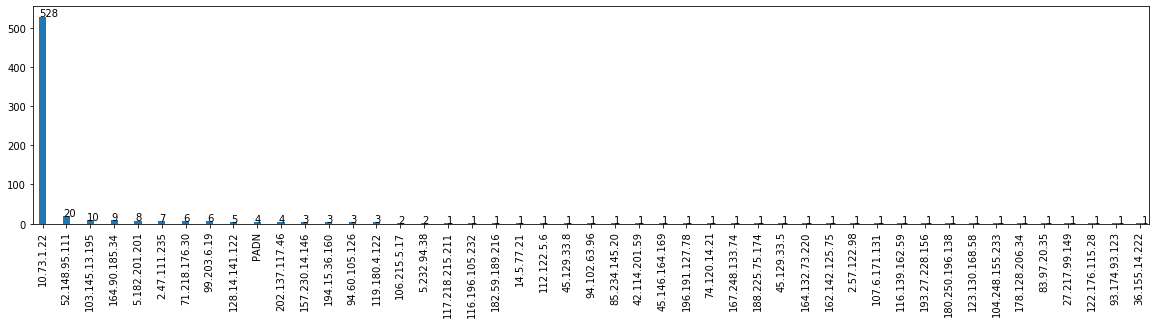

In [15]:
# 10-12 11:43 & 10-12 11:44 = Possible denial of service attack
is_date = (df['date_minutes'] == '10-12 11:43') | (df['date_minutes'] == '10-12 11:44')
is_date_df = df[is_date]
is_date_df
# list source ips involved in the attack
ax = is_date_df[18].value_counts().plot(kind='bar',figsize=(20,4), width=0.3)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

# Dangerous IP is 10.73.1.22
No details - internal IP?

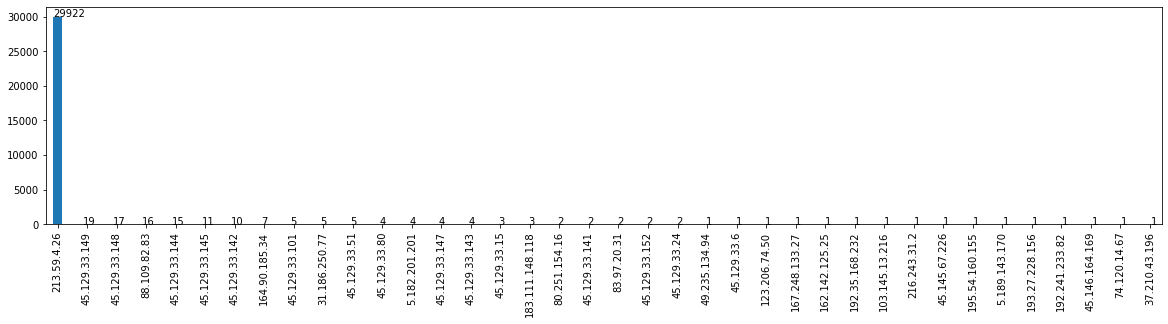

In [16]:
# 10-11 22:26 = Possible denial of service attack
is_date = (df['date_minutes'] == '10-11 22:26')
is_date_df = df[is_date]
is_date_df
# list source ips involved in the attack
ax = is_date_df[18].value_counts().plot(kind='bar',figsize=(20,4), width=0.3)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

# Dangerous IP is 213.59.4.26
- Country	Russia
- Organization	Rostelecom
- ISP	Rostelecom
- Last Update	2020-12-26T22:34:54.844550
- ASN	AS8342